Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

------------------------------------ FACTOR BETAS (Monthly Regression) ------------------------------------
      Mkt-RF    SMB    HML    RMW    CMA    Mom
NVDA   2.113 -0.260 -1.255  0.358  0.087 -0.146
PG     0.488 -0.258 -0.139  0.787  0.652  0.079
SPY    0.995 -0.102  0.010  0.081  0.040 -0.028

------------------------------------ ALPHA (Monthly) ------------------------------------
NVDA    0.0398
PG     -0.0073
SPY     0.0001
dtype: float64

------------------------------------ WEIGHTS (Two-Asset Universe) ------------------------------------
      MinVar  MinCVaR  MaxSharpe
PG    0.8863   0.9001     0.2935
NVDA  0.1137   0.0999     0.7065

------------------------------------ PERFORMANCE (Daily Backtest) ------------------------------------
                  AnnReturn  AnnVol  Sharpe  MaxDrawdown  CVaR_5pct
RiskAverse_Stock     0.0734  0.1853  0.39

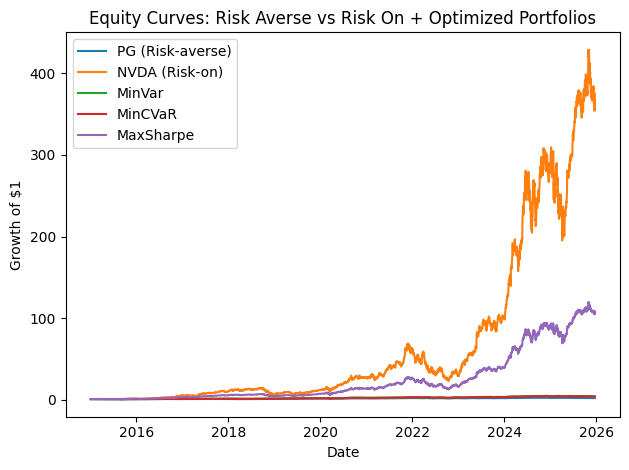

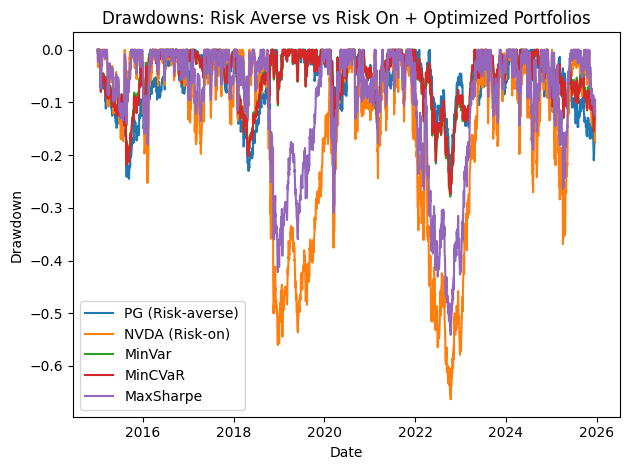

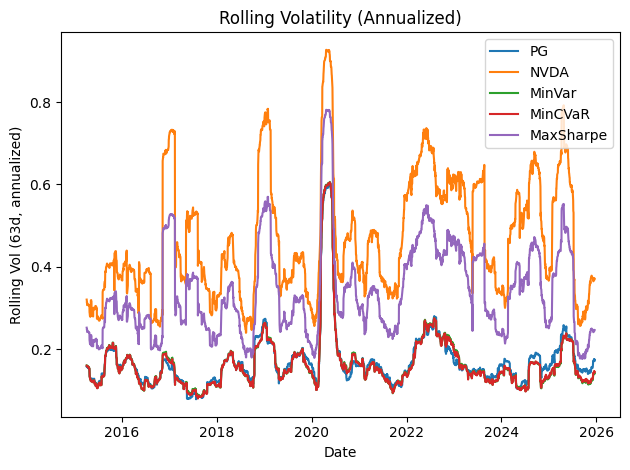

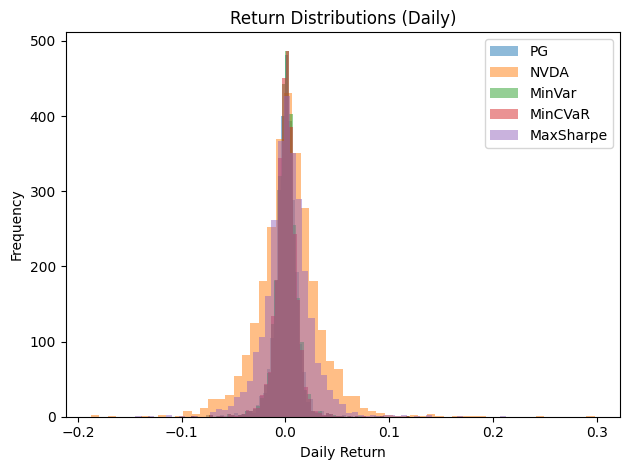

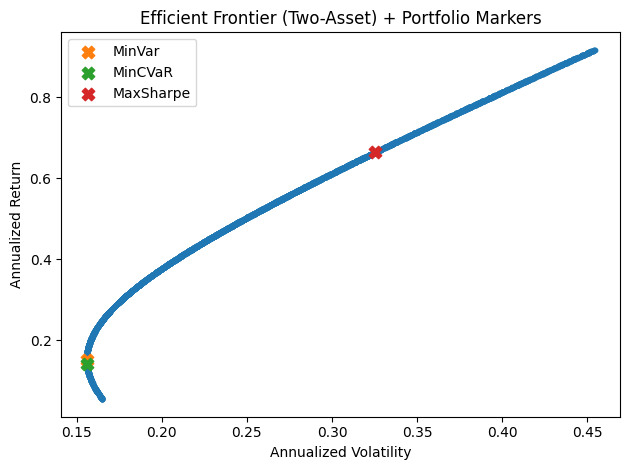

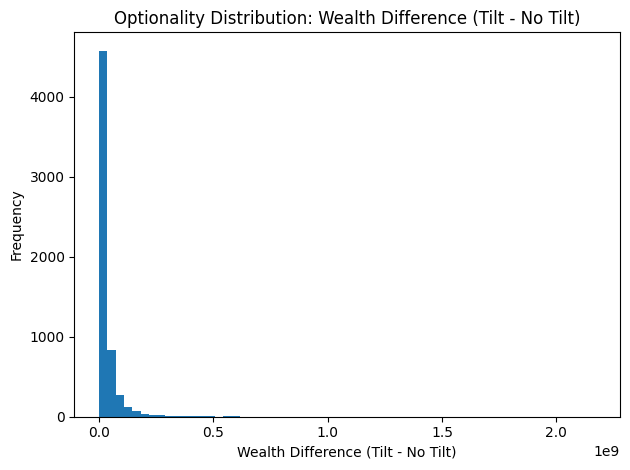

In [2]:
"""Yariverse optionality model: stock version"""

%pip install yfinance
%pip install pandas_datareader

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr

from sklearn.covariance import LedoitWolf
import statsmodels.api as sm
from scipy.optimize import minimize

#User Inputs
#------------------------------------------------------------------------------------------------------------------------------
START = "2015-01-01"
END   = "2025-12-20"

#Two stock options (edit freely)
RISK_AVERSE_TICKER = "PG"     # defensive ex
RISK_ON_TICKER     = "NVDA"   # risk on ex
BENCH_TICKER       = "SPY"

TICKERS = [RISK_AVERSE_TICKER, RISK_ON_TICKER, BENCH_TICKER]

TRADING_DAYS = 252
ROLL_WIN = 63  #approx. 3 months

#Optionality overlay interpreted as "tilt to risk-on" behavior during a window
INITIAL_WEALTH = 25_000
BASE_CONTRIB_M = 500
HORIZON_YEARS  = 20

TILT_START_Y = 2
TILT_END_Y   = 12

#Extra monthly contribution during the tilt window (toy mechanism)
EXTRA_CONTRIB_TILT = 250

#Efficient frontier settings
N_FRONTIER = 4000
SEED_FRONTIER = 123

#Data Helpers
#------------------------------------------------------------------------------------------------------------------------------
def get_prices(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame()
    df = df.dropna(how="all").ffill().dropna()
    return df

def to_returns(prices):
    return prices.pct_change().dropna()

def align_monthly(daily_returns):
    m = (1 + daily_returns).resample("M").prod() - 1
    return m.dropna()

def get_factors_ff_monthly(start, end):
    ff5 = pdr.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench")[0]
    mom = pdr.DataReader("F-F_Momentum_Factor", "famafrench")[0]

    ff5.index = pd.to_datetime(ff5.index.astype(str)) + pd.offsets.MonthEnd(0)
    mom.index = pd.to_datetime(mom.index.astype(str)) + pd.offsets.MonthEnd(0)

    factors = ff5.join(mom, how="inner")
    factors = factors.rename(columns={"Mom   ": "MOM"})
    factors = factors / 100.0
    factors = factors.loc[(factors.index >= pd.to_datetime(start)) & (factors.index <= pd.to_datetime(end))]
    return factors

#Factor Regression (Expected Returns)
#------------------------------------------------------------------------------------------------------------------------------
def factor_expected_returns(asset_monthly, factors_monthly):
    common = asset_monthly.index.intersection(factors_monthly.index)
    R = asset_monthly.loc[common]
    F = factors_monthly.loc[common]

    rf = F["RF"]
    X = F.drop(columns=["RF"]).copy()
    Ef = X.mean()

    exp = {}
    betas_out = {}
    alphas_out = {}

    for a in R.columns:
        y = (R[a] - rf).astype(float)
        Xc = sm.add_constant(X.astype(float))
        model = sm.OLS(y, Xc).fit()

        alpha = model.params["const"]
        betas = model.params.drop("const")

        Er = rf.mean() + alpha + float(np.dot(betas.values, Ef.values))
        exp[a] = Er
        betas_out[a] = betas
        alphas_out[a] = alpha

    return pd.Series(exp), pd.DataFrame(betas_out).T, pd.Series(alphas_out)


#Risk Model: Ledoit-Wolf Shrinkage Covariance
#------------------------------------------------------------------------------------------------------------------------------
def shrink_covariance(returns):
    lw = LedoitWolf().fit(returns.values)
    cov = pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns)
    return cov

#Annualization Helpers
#------------------------------------------------------------------------------------------------------------------------------
def annualize_mu(mu_m):
    return (1 + mu_m) ** 12 - 1

def annualize_cov(cov_m):
    return cov_m * 12

def portfolio_stats(w, mu_a, cov_a):
    w = np.asarray(w)
    ret = float(np.dot(w, mu_a))
    vol = float(np.sqrt(w.T @ cov_a.values @ w))
    sharpe = ret / vol if vol > 0 else np.nan
    return ret, vol, sharpe

#Tail Risk: CVaR
#------------------------------------------------------------------------------------------------------------------------------
def cvar_loss(returns, w, alpha=0.95):
    p = returns.values @ np.asarray(w)
    losses = -p
    q = np.quantile(losses, alpha)
    tail = losses[losses >= q]
    return float(np.mean(tail)) if len(tail) else float(q)

#Optimizers
#------------------------------------------------------------------------------------------------------------------------------
def max_sharpe(mu_a, cov_a, w_bounds=(0, 1)):
    n = len(mu_a)
    bounds = [w_bounds] * n
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    w0 = np.repeat(1 / n, n)

    def obj(w):
        r, v, s = portfolio_stats(w, mu_a.values, cov_a)
        return -s

    res = minimize(obj, w0, bounds=bounds, constraints=cons, method="SLSQP")
    return res.x, res

def min_variance(cov_a, w_bounds=(0, 1)):
    n = cov_a.shape[0]
    bounds = [w_bounds] * n
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    w0 = np.repeat(1 / n, n)

    def obj(w):
        return float(w.T @ cov_a.values @ w)

    res = minimize(obj, w0, bounds=bounds, constraints=cons, method="SLSQP")
    return res.x, res

def min_cvar(returns, w_bounds=(0, 1), alpha=0.95):
    n = returns.shape[1]
    bounds = [w_bounds] * n
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    w0 = np.repeat(1 / n, n)

    def obj(w):
        return cvar_loss(returns, w, alpha=alpha)

    res = minimize(obj, w0, bounds=bounds, constraints=cons, method="SLSQP")
    return res.x, res

#Backtest + Metrics
#------------------------------------------------------------------------------------------------------------------------------
def equity_curve(daily_rets):
    return (1 + daily_rets).cumprod()

def max_drawdown(eq):
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return float(dd.min())

def perf_metrics(daily_port_rets):
    eq = equity_curve(daily_port_rets)
    ann_ret = float(eq.iloc[-1] ** (TRADING_DAYS / len(eq)) - 1)
    ann_vol = float(daily_port_rets.std() * np.sqrt(TRADING_DAYS))
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    mdd = max_drawdown(eq.values)
    sorted_rets = np.sort(daily_port_rets.values)
    tail_n = max(1, int(0.05 * len(sorted_rets)))
    cvar5 = float(np.mean(sorted_rets[:tail_n]))
    return {
        "AnnReturn": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "MaxDrawdown": mdd,
        "CVaR_5pct": cvar5
    }

#Efficient Frontier
#------------------------------------------------------------------------------------------------------------------------------
def random_simplex_weights(n, rng):
    x = rng.random(n)
    return x / x.sum()

def efficient_frontier(mu_a, cov_a, n_samples=4000, seed=123):
    rng = np.random.default_rng(seed)
    assets = list(mu_a.index)
    n = len(assets)

    rows = []
    for _ in range(n_samples):
        w = random_simplex_weights(n, rng)
        r, v, s = portfolio_stats(w, mu_a.values, cov_a.loc[assets, assets])
        rows.append([r, v, s] + list(w))

    cols = ["Return", "Vol", "Sharpe"] + [f"w_{a}" for a in assets]
    return pd.DataFrame(rows, columns=cols)

#Optionality Overlay: Tilt vs No Tilt
#------------------------------------------------------------------------------------------------------------------------------
def simulate_tilt_optionality(monthly_mu, monthly_var, n_sims=6000, seed=19):
    rng = np.random.default_rng(seed)
    months = HORIZON_YEARS * 12
    mu = float(monthly_mu)
    sigma = float(np.sqrt(monthly_var))

    start_idx = TILT_START_Y * 12
    end_idx = TILT_END_Y * 12

    final_no = np.zeros(n_sims)
    final_yes = np.zeros(n_sims)

    for i in range(n_sims):
        r = rng.normal(mu, sigma, size=months)

        # No tilt
        w = INITIAL_WEALTH
        for t in range(months):
            w = w * (1 + r[t]) + BASE_CONTRIB_M
        final_no[i] = w

        # Tilt
        w = INITIAL_WEALTH
        for t in range(months):
            extra = EXTRA_CONTRIB_TILT if start_idx <= t < end_idx else 0.0
            w = w * (1 + r[t]) + BASE_CONTRIB_M + extra
        final_yes[i] = w

    diff = final_yes - final_no
    summary = {
        "NoTilt_median": float(np.median(final_no)),
        "Tilt_median": float(np.median(final_yes)),
        "Diff_median": float(np.median(diff)),
        "Diff_p10": float(np.percentile(diff, 10)),
        "Diff_p90": float(np.percentile(diff, 90)),
        "NoTilt_mean": float(np.mean(final_no)),
        "Tilt_mean": float(np.mean(final_yes)),
        "Diff_mean": float(np.mean(diff)),
    }
    return summary, final_no, final_yes, diff

#Plotting
#------------------------------------------------------------------------------------------------------------------------------
def plot_equity_curves(curves, title):
    plt.figure()
    for name, series in curves.items():
        plt.plot(series.index, series.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.tight_layout()

def plot_drawdowns(curves, title):
    plt.figure()
    for name, eq in curves.items():
        peak = eq.cummax()
        dd = eq / peak - 1.0
        plt.plot(dd.index, dd.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.tight_layout()

def plot_rolling_vol(daily_returns, title, window=63):
    plt.figure()
    for name, r in daily_returns.items():
        rv = r.rolling(window).std() * np.sqrt(TRADING_DAYS)
        plt.plot(rv.index, rv.values, label=name)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(f"Rolling Vol ({window}d, annualized)")
    plt.legend()
    plt.tight_layout()

def plot_return_hist(daily_returns, title):
    plt.figure()
    for name, r in daily_returns.items():
        plt.hist(r.dropna().values, bins=60, alpha=0.5, label=name)
    plt.title(title)
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()

def plot_frontier(frontier_df, portfolio_points, title):
    plt.figure()
    plt.scatter(frontier_df["Vol"], frontier_df["Return"], s=10)
    for name, (vol, ret) in portfolio_points.items():
        plt.scatter([vol], [ret], s=80, marker="X", label=name)
    plt.title(title)
    plt.xlabel("Annualized Volatility")
    plt.ylabel("Annualized Return")
    plt.legend()
    plt.tight_layout()

def plot_optionality_hist(diff, title):
    plt.figure()
    plt.hist(diff, bins=60)
    plt.title(title)
    plt.xlabel("Wealth Difference (Tilt - No Tilt)")
    plt.ylabel("Frequency")
    plt.tight_layout()

#Run
#------------------------------------------------------------------------------------------------------------------------------
def main():
    prices = get_prices(TICKERS, START, END)
    rets_d = to_returns(prices)
    rets_m = align_monthly(rets_d)

    factors = get_factors_ff_monthly(START, END)

    mu_m, betas_df, alphas_s = factor_expected_returns(rets_m, factors)
    cov_m = shrink_covariance(rets_m)

    mu_a = annualize_mu(mu_m)
    cov_a = annualize_cov(cov_m)

    two_assets = [RISK_AVERSE_TICKER, RISK_ON_TICKER]
    two_d = rets_d[two_assets].dropna()

    w_minv, _ = min_variance(cov_a.loc[two_assets, two_assets], w_bounds=(0, 1))
    w_cvar, _ = min_cvar(two_d, w_bounds=(0, 1), alpha=0.95)
    w_msr,  _ = max_sharpe(mu_a.loc[two_assets], cov_a.loc[two_assets, two_assets], w_bounds=(0, 1))

    weights = pd.DataFrame({"MinVar": w_minv, "MinCVaR": w_cvar, "MaxSharpe": w_msr}, index=two_assets)

    r_averse = two_d[RISK_AVERSE_TICKER]
    r_on     = two_d[RISK_ON_TICKER]
    port_minv = two_d @ w_minv
    port_cvar = two_d @ w_cvar
    port_msr  = two_d @ w_msr

    stats = pd.DataFrame({
        "RiskAverse_Stock": perf_metrics(r_averse),
        "RiskOn_Stock": perf_metrics(r_on),
        "MinVar_Port": perf_metrics(port_minv),
        "MinCVaR_Port": perf_metrics(port_cvar),
        "MaxSharpe_Port": perf_metrics(port_msr)
    })

    print("\n------------------------------------ FACTOR BETAS (Monthly Regression) ------------------------------------")
    print(betas_df.round(3))
    print("\n------------------------------------ ALPHA (Monthly) ------------------------------------")
    print(alphas_s.round(4))
    print("\n------------------------------------ WEIGHTS (Two-Asset Universe) ------------------------------------")
    print(weights.round(4))
    print("\n------------------------------------ PERFORMANCE (Daily Backtest) ------------------------------------")
    print(stats.T.round(4))

    eq = {
        f"{RISK_AVERSE_TICKER} (Risk-averse)": equity_curve(r_averse),
        f"{RISK_ON_TICKER} (Risk-on)": equity_curve(r_on),
        "MinVar": equity_curve(port_minv),
        "MinCVaR": equity_curve(port_cvar),
        "MaxSharpe": equity_curve(port_msr),
    }
    plot_equity_curves(eq, "Equity Curves: Risk Averse vs Risk On + Optimized Portfolios")
    plot_drawdowns(eq, "Drawdowns: Risk Averse vs Risk On + Optimized Portfolios")

    rv_inputs = {RISK_AVERSE_TICKER: r_averse, RISK_ON_TICKER: r_on, "MinVar": port_minv, "MinCVaR": port_cvar, "MaxSharpe": port_msr}
    plot_rolling_vol(rv_inputs, "Rolling Volatility (Annualized)", window=ROLL_WIN)
    plot_return_hist(rv_inputs, "Return Distributions (Daily)")

    frontier = efficient_frontier(mu_a.loc[two_assets], cov_a.loc[two_assets, two_assets], n_samples=N_FRONTIER, seed=SEED_FRONTIER)

    def ann_point(w):
        r, v, _ = portfolio_stats(w, mu_a.loc[two_assets].values, cov_a.loc[two_assets, two_assets])
        return v, r

    portfolio_points = {"MinVar": ann_point(w_minv), "MinCVaR": ann_point(w_cvar), "MaxSharpe": ann_point(w_msr)}
    plot_frontier(frontier, portfolio_points, "Efficient Frontier (Two-Asset) + Portfolio Markers")

    port_msr_m = (1 + port_msr).resample("M").prod() - 1
    mu_engine_m = float(port_msr_m.mean())
    var_engine_m = float(port_msr_m.var())

    opt_summary, _, _, diff = simulate_tilt_optionality(mu_engine_m, var_engine_m, n_sims=6000, seed=19)

    print("\n=------------------------------------ OPTIONALITY OVERLAY (TILT vs NO TILT) ------------------------------------")
    print(pd.Series(opt_summary).round(2))

    plot_optionality_hist(diff, "Optionality Distribution: Wealth Difference (Tilt - No Tilt)")
    plt.show()

if __name__ == "__main__":
    main()

